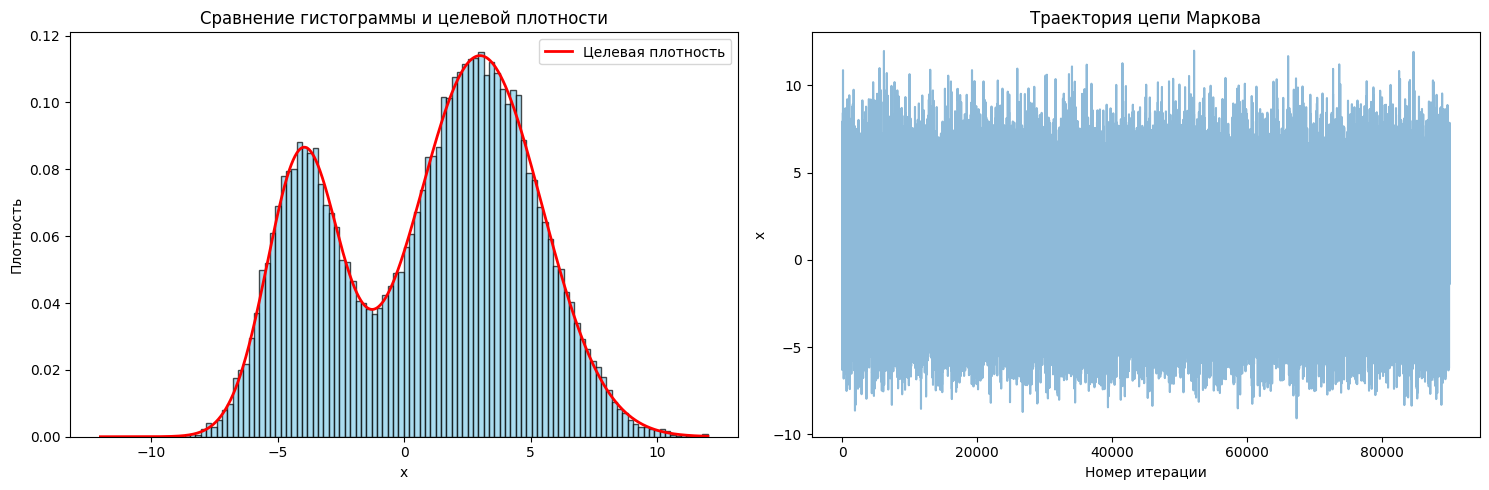

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

def target_density(x):
    return 0.3 * norm.pdf(x, loc=-4, scale=np.sqrt(2)) + 0.7 * norm.pdf(x, loc=3, scale=np.sqrt(6))

n_samples = 100000
burn_in = 10000
proposal_sd = 3

samples = np.zeros(n_samples)
current_x = 0

for i in range(n_samples):
    proposed_x = norm.rvs(loc=current_x, scale=proposal_sd)
    acceptance_ratio = target_density(proposed_x) / target_density(current_x)
    if uniform.rvs() < acceptance_ratio:
        current_x = proposed_x
    samples[i] = current_x

post_burn_samples = samples[burn_in:]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(post_burn_samples, bins=100, density=True, alpha=0.7, color='skyblue', edgecolor='black')
x_vals = np.linspace(-12, 12, 1000)
y_vals = target_density(x_vals)
axes[0].plot(x_vals, y_vals, 'r-', linewidth=2, label='Целевая плотность')
axes[0].set_title('Сравнение гистограммы и целевой плотности')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Плотность')
axes[0].legend()

axes[1].plot(post_burn_samples, alpha=0.5)
axes[1].set_title('Траектория цепи Маркова')
axes[1].set_xlabel('Номер итерации')
axes[1].set_ylabel('x')

plt.tight_layout()
plt.show()

In [16]:
#действительно хорошо приближает

Ожидаемое среднее для 2x2: 1.142857
Полученное среднее для 2x2: 1.129600

Результаты для графа 10x10:
Оценка E[n(ξ)] = 23.7166


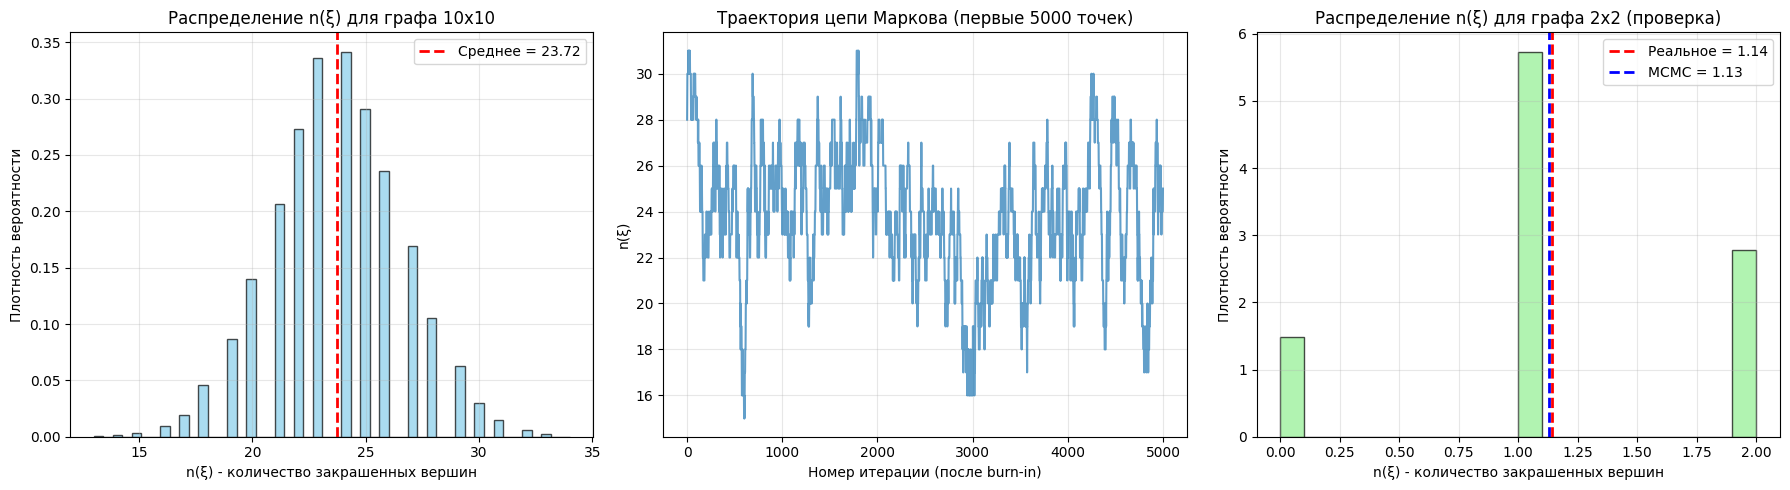

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class Graph:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.n_vertices = rows * cols
        self.adj_list = defaultdict(list)
        self._build_grid_graph()
    
    def _build_grid_graph(self):
        for i in range(self.rows):
            for j in range(self.cols):
                v = i * self.cols + j
                for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < self.rows and 0 <= nj < self.cols:
                        u = ni * self.cols + nj
                        self.adj_list[v].append(u)

def is_valid_config(config, v, new_value, adj_list):
    if new_value == 1:
        for neighbor in adj_list[v]:
            if config[neighbor] == 1:
                return False
    return True

def mcmc(graph, n_steps=100000, burn_in=10000):
    n_vertices = graph.n_vertices
    adj_list = graph.adj_list
    config = np.zeros(n_vertices, dtype=int)
    samples = []
    n_ones_history = []
    for step in range(n_steps):
        v = np.random.randint(0, n_vertices)
        current_value = config[v]
        new_value = 1 - current_value
        if is_valid_config(config, v, new_value, adj_list):
            if np.random.random() < 0.5:
                config[v] = new_value
        if step >= burn_in:
            n_ones = np.sum(config)
            samples.append(n_ones)
            n_ones_history.append(n_ones)
    return samples, n_ones_history
    
graph_2x2 = Graph(2, 2)
samples_2x2, history_2x2 = mcmc(graph_2x2, n_steps=20000, burn_in=5000)
actual_2x2 = np.mean(samples_2x2)
print(f"Ожидаемое среднее для 2x2: {(8/7):.6f}")
print(f"Полученное среднее для 2x2: {actual_2x2:.6f}")

graph_10x10 = Graph(10, 10)
samples_10x10, history_10x10 = mcmc(graph_10x10, n_steps=100000, burn_in=20000)
expected_n = np.mean(samples_10x10)
std_n = np.std(samples_10x10)

print(f"\nРезультаты для графа 10x10:")
print(f"Оценка E[n(ξ)] = {expected_n:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(samples_10x10, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(expected_n, color='red', linestyle='--', linewidth=2, label=f'Среднее = {expected_n:.2f}')
axes[0].set_xlabel('n(ξ) - количество закрашенных вершин')
axes[0].set_ylabel('Плотность вероятности')
axes[0].set_title('Распределение n(ξ) для графа 10x10')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_10x10[:5000], alpha=0.7)
axes[1].set_xlabel('Номер итерации (после burn-in)')
axes[1].set_ylabel('n(ξ)')
axes[1].set_title('Траектория цепи Маркова (первые 5000 точек)')
axes[1].grid(alpha=0.3)

axes[2].hist(samples_2x2, bins=20, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
axes[2].axvline(expected_2x2, color='red', linestyle='--', linewidth=2, label=f'Реальное = {expected_2x2:.2f}')
axes[2].axvline(actual_2x2, color='blue', linestyle='--', linewidth=2, label=f'MCMC = {actual_2x2:.2f}')
axes[2].set_xlabel('n(ξ) - количество закрашенных вершин')
axes[2].set_ylabel('Плотность вероятности')
axes[2].set_title('Распределение n(ξ) для графа 2x2 (проверка)')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()